<a href="https://colab.research.google.com/github/filbertumbawa15/bio/blob/master/BgWin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd '/./content/gdrive/My Drive/Kaggle'

/content/gdrive/My Drive/Kaggle


In [3]:
train_dir = '/content/gdrive/My Drive/Kaggle/DATASET/TRAIN'
test_dir = '/content/gdrive/My Drive/Kaggle/DATASET/TEST'

In [4]:
# import needed libraries
from tensorflow import keras
from keras.applications import EfficientNetB7
from keras.layers import RandomFlip, RandomRotation, GlobalAveragePooling2D, Dropout, Dense
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
from skimage import io
%matplotlib inline

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   validation_split=0.2)


val_datagen = ImageDataGenerator(rescale = 1./255,
                                 validation_split=0.5)

In [6]:
Batch_size = 32

train_set = train_datagen.flow_from_directory(train_dir, class_mode='binary',
                                              batch_size = Batch_size,
                                              target_size=(64, 64))


val_set = val_datagen.flow_from_directory(test_dir, class_mode='binary',
                                          batch_size = Batch_size,
                                          target_size=(64, 64),
                                          subset= 'training')


test_set = val_datagen.flow_from_directory(test_dir, class_mode = 'binary',
                                           batch_size = Batch_size,
                                           target_size=(64, 64),
                                           subset= 'validation')

Found 22564 images belonging to 2 classes.
Found 1257 images belonging to 2 classes.
Found 1256 images belonging to 2 classes.


In [7]:
train_set.class_indices

{'O': 0, 'R': 1}

In [8]:
train_set.image_shape

(64, 64, 3)

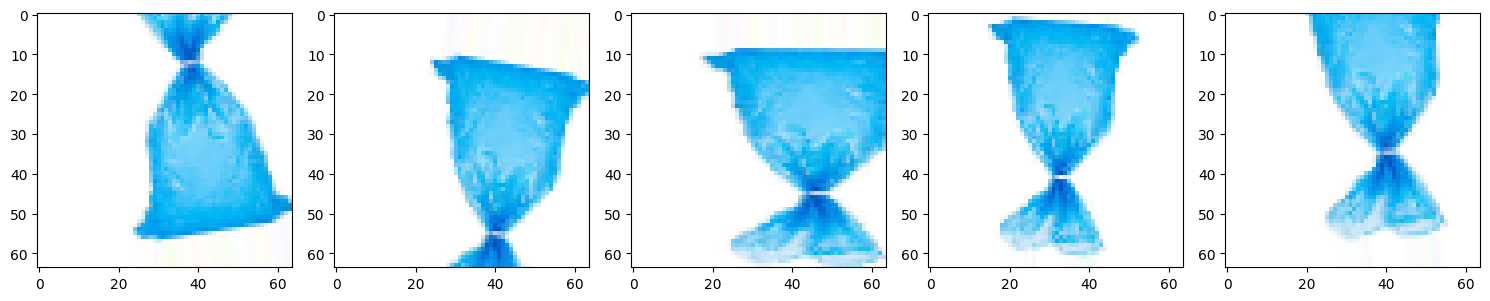

In [9]:
def Images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_img = [train_set[0][0][0] for i in range(5)]
Images(augmented_img)

In [10]:
# use EfficientNet-B7 as base model
base_model = EfficientNetB7(
    input_shape=(64, 64, 3),
    weights='imagenet',
    include_top=False
)
base_model.trainable = False
base_model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnetb7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 64, 64, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 64, 64, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 65, 65, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 64)     │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 64)     │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 64)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 32, 32, 64)     │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 32, 32, 64)     │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 32, 32, 64)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [ ]:
# Load the pre-trained EfficientNetB7 base model
base_model = EfficientNetB7(
    include_top=False,  # Exclude the top (fully connected) layers
    weights='imagenet',  # Use pretrained ImageNet weights
    input_shape=(600, 600, 3)  # Adjust input shape for EfficientNetB7
)

# Freeze the base model layers
base_model.trainable = False  # Fine-tuning can be done later if needed

# Build the custom classification head
inputs = keras.Input(shape=(64, 64, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.5)(x)              # Add dropout for regularization
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Add another dropout
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the model
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Low learning rate for transfer learning
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy']
)

model.summary()

In [11]:
# # modeling
# data_augmentation = keras.Sequential(
#   [RandomFlip(), RandomRotation(0.2)],
#   'augmentation'
# )

# inputs = keras.Input(shape=(64, 64, 3))
# x = data_augmentation(inputs)
# x = base_model(x, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# outputs = Dense(9, activation='softmax')(x)
# model = keras.Model(inputs, outputs)

# model.compile(
#   loss='categorical_crossentropy',
#   optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Lower learning rate
#   metrics=[CategoricalAccuracy(), Precision(), Recall()]
# )

# model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb7 (Functional)          │ (None, 2, 2, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9)                   │          23,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,120,736 (244.60 MB)

 Trainable params: 23,049 (90.04 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [12]:
# use EarlyStopping callback
es = EarlyStopping(monitor='loss', patience=10)

# use ModelCheckpoint callback
mc_filepath = 'model_checkpoint/best_weights.weights.h5'
mc = ModelCheckpoint(
  filepath=mc_filepath,
  monitor='loss',
  save_best_only=True,
  save_weights_only=True
)

In [13]:
# train model
epochs = 5
history = model.fit(train_set,validation_data=val_set, epochs=epochs, callbacks=[es, mc])

Epoch 1/5


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 9)